# Preparing data for Modelling

In [1]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.cm as cm
plt.style.use('ggplot')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MaxAbsScaler, PowerTransformer
from sklearn.base import clone

import seaborn as sns

import quantstats as qs
import os 
# pd.set_option('display.max_rows', None)
import os 

# To automatically load changes in different files 
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
# Applying Settings to Viaualization Tools 
plt.rcParams['font.size'] = 13
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
# Set color palette to blue shades
sns.set_palette(["#003366", "#6699CC", "#99CCFF", "#99CCFF"])
sns.set_palette(["#002855", "#3E7EAA", "#82B5D8", "#B3D9F2"])
plt.rcParams['font.family'] = 'Times New Roman'
sns.set_style("darkgrid")

from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, mean_absolute_percentage_error
import statsmodels.api as sm

import xgboost
from xgboost import XGBRegressor
# create an xgboost regression model

import tqdm 
from tqdm import tqdm 

In [2]:
from utils import search_folder
current_dir = os.getcwd()
thesis_folder_path = current_dir.replace("thesis_code", "")
twitter_data_path = search_folder(thesis_folder_path,"twitter_data")
eikon_data_path = search_folder(thesis_folder_path,"eikon_news")
stock_data_path = search_folder(thesis_folder_path,"stock_prices")
modelling_data_path = search_folder(thesis_folder_path,"modelling_data")
google_trending_path = search_folder(thesis_folder_path,"google_search")
results_folder = search_folder(thesis_folder_path,"results_output")

In [3]:
def read_modelling(path, name):
    df = pd.read_csv(path+name)
    df["datetime"] = pd.to_datetime(df["datetime"])
    df = df.sort_values(by = "datetime", ascending = True)
    df = df.reset_index(drop = True)
    return df

---
## Stock Data 

In [4]:
stock_data_df = read_modelling(modelling_data_path, "/all_stocks_returns_df.csv")
stock_data_df.head(3)

,datetime,close,net,ret,open,low,high,volume,turnover_usd,flow,company
0,2017-01-03,14.465986,NaN,NaN,14.323986,14.063986,14.688652,8.884890e+07,1.283684e+09,0.000000e+00,tesla
1,2017-01-03,29.037500,NaN,NaN,28.950000,28.690000,29.082500,1.151275e+08,3.327549e+09,0.000000e+00,apple
2,2017-01-04,29.005000,-0.0325,-0.001119,28.962500,28.937500,29.127500,8.447246e+07,2.452484e+09,-2.452484e+09,apple


---
## Fama French Model Features 

In [5]:
fama_french_feat_df = read_modelling(modelling_data_path, "/fama_variables_companies.csv")
fama_french_feat_df.head(3)

,datetime,beta_mktrf,beta_smb,beta_hml,beta_rmw,beta_cma,idvar_ff5,company
0,2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,moderna
1,2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,tesla
2,2017-01-03,NaN,NaN,NaN,NaN,NaN,NaN,apple


In [6]:
# # joining stock data with fama french factors
# master_table = pd.merge(stock_data_df, fama_french_feat_df, how = "left", left_on=["datetime", "company"], right_on = ["datetime", "company"])
# master_table = master_table.drop_duplicates()

---
## Sentiment Model Features 

In [7]:
sentiment_df = pd.read_csv(modelling_data_path + "/master_table_news_sentiment.csv")
sentiment_df["datetime"] = pd.to_datetime(sentiment_df["date"], utc = True)
sentiment_df = sentiment_df.sort_values(by = "datetime")
sentiment_df

,date,company,daytweets,textblob_tw_sw,vader_tw_sw,finbert_tw_sw,textblob_senti_sw,vader_sw,finbert_senti_sw,textblob_senti_tw,vader_senti_tw,finbert_senti_tw,news_count,eik_textblob_senti_sw,eik_finbert_senti_sw,eik_vader_senti_sw,textblob_eik_twi_senti,finbert_eik_twi_senti,vader_eik_twi_senti,datetime
0,2017-01-02,apple,195364,108.654740,145.5335,-35.0,50.796503,476,-22.0,57.858238,83.1307,-13.0,16.0,0.107143,-6.0,-0.2248,0.139497,0.330854,0.247211,2017-01-02 00:00:00+00:00
1,2017-01-02,google,32400,27.841547,4.7608,-50.0,11.939170,203,-23.0,15.902377,7.2756,-27.0,0.0,0.000000,0.0,0.0000,0.117251,0.340631,0.228702,2017-01-02 00:00:00+00:00
2,2017-01-02,tesla,27556,69.120491,56.5365,15.0,25.982624,181,0.0,43.137866,33.4803,15.0,1.0,0.000000,-1.0,0.0000,0.127801,0.342587,0.236034,2017-01-02 00:00:00+00:00
3,2017-01-03,apple,187489,100.070978,73.2125,-24.0,49.393965,462,-12.0,50.677013,32.8160,-12.0,4.0,0.000000,0.0,0.0000,0.135711,0.342123,0.238395,2017-01-03 00:00:00+00:00
4,2017-01-03,google,15876,19.047536,36.4611,-18.0,9.819791,135,-9.0,9.227745,16.5585,-9.0,0.0,0.000000,0.0,0.0000,0.115003,0.342467,0.233191,2017-01-03 00:00:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6210,2023-04-13,moderna,25,4.696667,2.5965,5.0,2.348333,5,3.0,2.348333,1.5842,2.0,0.0,0.000000,0.0,0.0000,0.111336,0.343787,0.228395,2023-04-13 00:00:00+00:00
6213,2023-04-14,google,961,6.778229,8.8280,-10.0,2.089114,34,-4.0,4.689114,5.1707,-6.0,0.0,0.000000,0.0,0.0000,0.111868,0.342926,0.229278,2023-04-14 00:00:00+00:00
6214,2023-04-14,moderna,289,3.375763,4.5592,16.0,1.622256,18,8.0,1.753506,2.6954,8.0,0.0,0.000000,0.0,0.0000,0.110998,0.344418,0.228673,2023-04-14 00:00:00+00:00
6212,2023-04-14,apple,13924,42.478908,52.1386,8.0,23.767439,126,1.0,18.711469,24.3339,7.0,0.0,0.000000,0.0,0.0000,0.120992,0.343959,0.235411,2023-04-14 00:00:00+00:00


---
## Topic Modelling Features

---
## Google Trending News for Companies

In [8]:
comp_google_search_df = read_modelling(modelling_data_path, "/google_searches_companies.csv")
comp_google_search_df.head()

,datetime,interest,company
0,2018-04-08,31,apple
1,2018-04-15,1,moderna
2,2018-04-15,33,apple
3,2018-04-15,18,tesla
4,2018-04-22,31,apple


In [9]:
from utils import fix_dates
comp_google_search_df["datetime"] = comp_google_search_df["datetime"].apply(lambda x: fix_dates(x))
comp_google_search_df.head()

,datetime,interest,company
0,2018-04-09,31,apple
1,2018-04-16,1,moderna
2,2018-04-16,33,apple
3,2018-04-16,18,tesla
4,2018-04-23,31,apple


---
## Google Trending News for Macro-News

In [10]:
makro_google_search_df = read_modelling(modelling_data_path, "/google_macro_searches.csv")
makro_google_search_df.head(3)

,datetime,pandemic_mentions,inflation_mentions
0,2018-04-08,1,17
1,2018-04-15,1,16
2,2018-04-22,1,17


In [11]:
makro_google_search_df["datetime"] = makro_google_search_df["datetime"].apply(lambda x: fix_dates(x))
makro_google_search_df.head(3)

,datetime,pandemic_mentions,inflation_mentions
0,2018-04-09,1,17
1,2018-04-16,1,16
2,2018-04-23,1,17


---
## Macro-Economic Data

In [12]:
macro_data_df = read_modelling(modelling_data_path, "/macro_data.csv")
macro_data_df.head(3)

,datetime,euro_doll_bid,euro_doll_ask,eur_doll_high,eur_doll_low,eur_doll_open,refresh_rate,euro_doll_bidnet,nasdaq_close,nasdaqd_net,nasdaqd_ret,nasdaq_open,nasdaq_low,nasdaq_high,nasdaq_volume
0,2017-01-03,1.0404,1.0408,1.0490,1.0339,1.0453,74707.0,-0.0053,4911.334,NaN,NaN,4900.854,4884.522,4928.490,152438794
1,2017-01-04,1.0486,1.0490,1.0499,1.0387,1.0403,91660.0,0.0082,4937.205,25.871,0.005268,4920.792,4919.803,4944.745,141126335
2,2017-01-05,1.0603,1.0611,1.0615,1.0478,1.0489,103626.0,0.0117,4964.953,27.748,0.005620,4936.355,4935.343,4967.901,140485654


---
## Features Table

In [13]:
# joining stock data with fama french factors
master_table = pd.merge(stock_data_df, fama_french_feat_df, how = "left", left_on=["datetime", "company"], right_on = ["datetime", "company"])
master_table = master_table.drop_duplicates()

#  joining master table with macro data from Eikon 
master_table = pd.merge(master_table, macro_data_df, how = "left", left_on=["datetime"], right_on = ["datetime"])
master_table = master_table.drop_duplicates()

# Joining master table with makro data from google search 
master_table = pd.merge(master_table, makro_google_search_df, how = "left", left_on=["datetime"], right_on = ["datetime"])
master_table = master_table.drop_duplicates()

# Joining master table with makro data from google search 
master_table = pd.merge(master_table, comp_google_search_df, how = "left", left_on=["datetime", "company"], right_on = ["datetime", "company"])
master_table = master_table.drop_duplicates()

--- 
### 7 - Additional Features: (Technical Analysis, Sentiment, Price patterns, etc.)

In [14]:
def prepare_df(df, col_to_pred : str, Ssenti_vars: list, lag):
    
    window = 10
    df["sma"] = df["close"].rolling(window=window, min_periods=1).mean()
    sma = df["close"].rolling(window=window, min_periods=1).mean()
    
    # Calculate RSI (Relative Strength Index)
    diff = df["close"].diff()
    up, down = diff.copy(), diff.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    avg_gain = up.rolling(window=window, min_periods=1).mean()
    avg_loss = abs(down.rolling(window=window, min_periods=1).mean())
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df["rsi"] = rsi

    # Calculate MACD (Moving Average Convergence Divergence)
    ema_12 = df["close"].ewm(span=12, adjust=False).mean()
    ema_26 = df["close"].ewm(span=26, adjust=False).mean()
    macd = ema_12 - ema_26
    df["macd"] = macd
    signal = macd.ewm(span=9, adjust=False).mean()
    df["signal"] = signal

    # Calculate Bollinger Bands
    rolling_std = df["close"].rolling(window=window, min_periods=1).std()
    upper_band = sma + 2 * rolling_std
    lower_band = sma - 2 * rolling_std
    
    df["rolling_std"] = rolling_std
    
    df["upper_bollinger"] = df["close"] > upper_band
    df["lower_bollinger"] = df["close"] < lower_band
    
    
    df["upper_bollinger"] = df["upper_bollinger"].apply(lambda x : 1 if x == True else 0)
    df["lower_bollinger"] = df["lower_bollinger"].apply(lambda x : 1 if x == True else 0)

    # Computing 1 day forward target prediction  
    target_var = "ft_target"
    df["ft_target"] = df[col_to_pred].shift(-lag)
    
    for lag in range(0,11): 
        df["lag_"+ str(lag)] = df[col_to_pred].shift(lag)
         
    df['mean2w'] = df["lag_0"].rolling(window=10).mean()
    df['std2w'] = df["lag_0"].rolling(window=10).std()
    df['std1w'] = df["lag_0"].rolling(window=5).std()
    
    for senti_var in Ssenti_vars: 
        for lag in range(1, 380, 10): 
            df["rolled_"+ senti_var + "_" +str(lag)] = df[senti_var].rolling(window = lag, min_periods=0).sum()
            
    for senti_var in Ssenti_vars: 
        for lag in range(2, 20, 1): 
            df["rolled_"+ senti_var + "_" +str(lag)] = df[senti_var].rolling(window = lag, min_periods=0).sum()
     
    df = df.drop(columns = [col_to_pred])
    
    df = df.drop_duplicates()
    
    df.fillna(0.0)

    return df

---
### Selecting Company and Adding Sentiment Variables

In [15]:
company = "moderna"
comp_pred_df = master_table[master_table["company"] == company]
comp_pred_df.loc[:, "interest"] = comp_pred_df["interest"].ffill().fillna(0.0) # modify the original DataFrame using .loc
comp_pred_df.loc[:, "rolling_interest"] = comp_pred_df["interest"].rolling(3).mean().ffill().fillna(0.0)
comp_pred_df.loc[:, "pandemic_mentions"] = comp_pred_df["pandemic_mentions"].ffill().fillna(0.0)
comp_pred_df.loc[:, "inflation_mentions"] = comp_pred_df["inflation_mentions"].ffill().fillna(0.0)

# Selecting company
single_sentiment_df = sentiment_df[sentiment_df["company"] == company]
single_sentiment_df = single_sentiment_df.sort_values(by = "datetime")

comp_pred_df["datetime"] = pd.to_datetime(comp_pred_df["datetime"], utc = True)

# Merging Sentimnent with company data 
comp_pred_df_senti = pd.merge(comp_pred_df, single_sentiment_df, how = "left", on = ["datetime"])

senti_vars = list(sentiment_df.columns[3:-1])
senti_vars.remove("news_count")

# Compute technical labels and fill NaN values with 0.0
comp_pred_final_df = prepare_df(comp_pred_df_senti, "close", senti_vars, 1)
comp_pred_final_df = comp_pred_final_df.fillna(0.0)

# Define lists of column names
macro_vars = [ 'open', 'low', 'high', 'volume', 'euro_doll_bid', 'euro_doll_ask', 'eur_doll_high', 'eur_doll_low', 'eur_doll_open', 'refresh_rate', 
              'euro_doll_bidnet', 'nasdaq_close', 'nasdaqd_net', 'nasdaqd_ret', 'nasdaq_open', 'nasdaq_low', 'nasdaq_high', 'nasdaq_volume'
              ]

google_vars = ["pandemic_mentions", "inflation_mentions", 'interest', 'rolling_interest']

lagged_vars = ['lag_0', 'lag_1', 'lag_2', 'lag_3', 'lag_4',    'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', "lag_10"]

techni_vars = ['mean2w', 'std2w', 'std1w']

fama_vars = ['beta_mktrf', 'beta_smb', 'beta_hml', 'beta_rmw', 'beta_cma']

technical_vars = ["sma", "rsi", "macd", "signal", "rolling_std", "upper_bollinger", "lower_bollinger"]

Csenti_vars = list(comp_pred_final_df.columns[75:])
Csenti_vars += ["daytweets", "news_count"]
date = ["datetime"]
ft_target = ["ft_target"]

#Csenti_vars.sort(reverse=True)
from utils import plot_three_line_chart

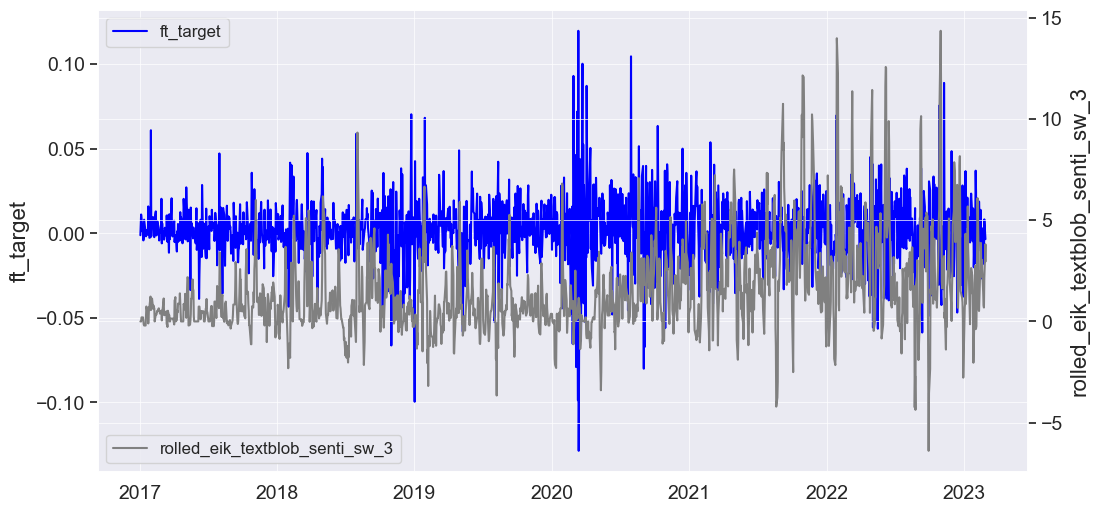

In [70]:
plot_three_line_chart(comp_pred_df_senti, "datetime", "ft_target","rolled_eik_textblob_senti_sw_3")

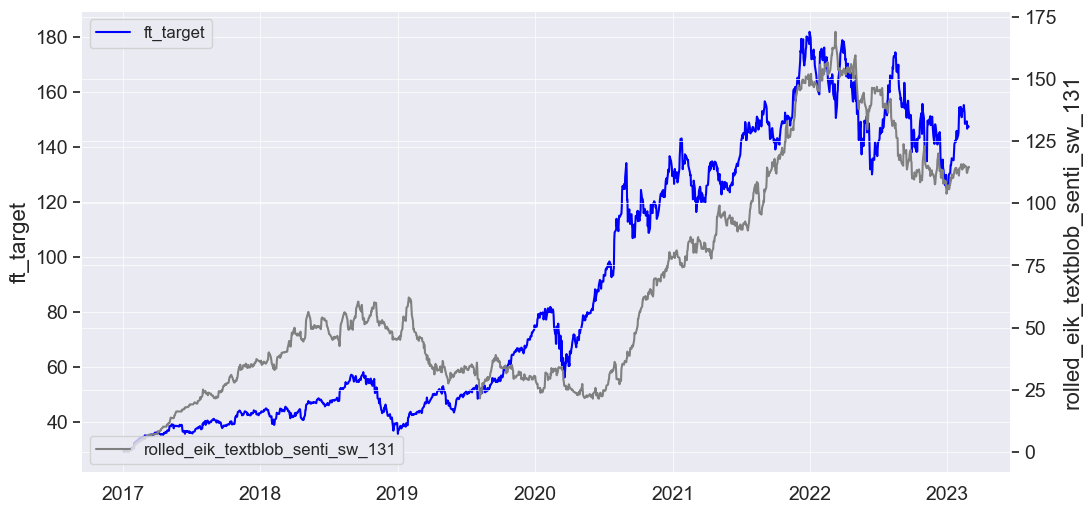

In [19]:
plot_three_line_chart(comp_pred_df_senti, "datetime", "ft_target","rolled_eik_textblob_senti_sw_131")

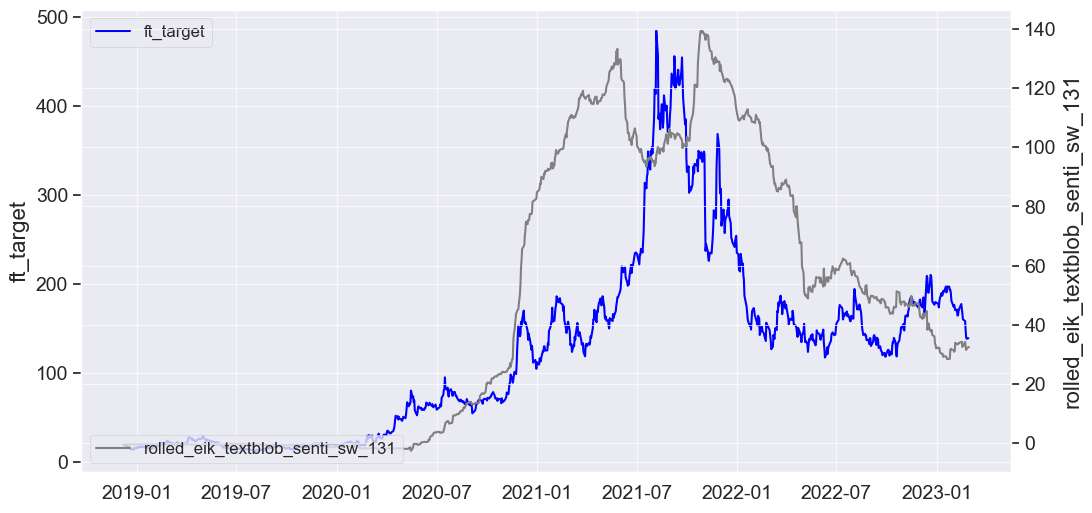

In [45]:
plot_three_line_chart(comp_pred_df_senti, "datetime", "ft_target","rolled_eik_textblob_senti_sw_131")

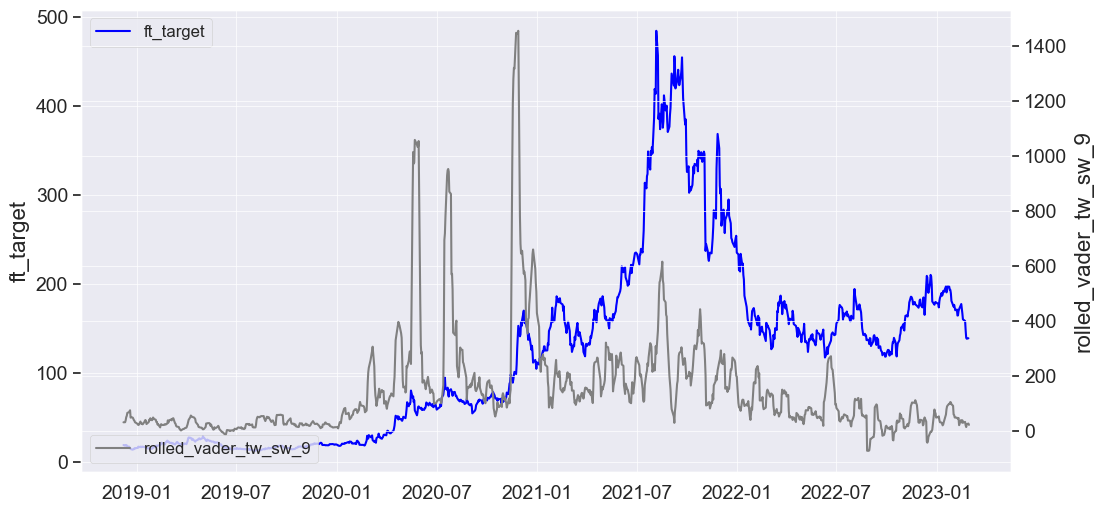

In [64]:
plot_three_line_chart(comp_pred_df_senti, "datetime", "ft_target","rolled_vader_tw_sw_9")

In [20]:
Ssenti_vars = ["rolled_Vader_sentim_351","rolled_eik_vader_senti_sw_21"]#  -> best results so far moderna

In [16]:
from class_backtester import Backtester as bk 
#model_config = {'model': {'alpha_estimation_method':'Lasso', "alpha": 0.1}}
model_config = {'model': {'alpha_estimation_method':'xgboost'}}

In [ ]:
for senti_var in tqdm(range(len(Csenti_vars))):
        try:
                all_feat = None 
                modelling_ft = None
                all_feat = date + macro_vars + google_vars + lagged_vars + techni_vars + fama_vars + ft_target  + technical_vars + [Csenti_vars[senti_var]]
                modelling_ft = macro_vars + google_vars + lagged_vars + techni_vars + fama_vars  + technical_vars + [Csenti_vars[senti_var]]
                comp_pred_final = comp_pred_final_df[all_feat]
                comp_pred_final = comp_pred_final.iloc[:-1,:]
                comp_pred_final = comp_pred_final[comp_pred_final["datetime"] <= "2023-02-15 00:00:00+00:00"]
                all_results_df = pd.read_csv(results_folder + "/moderna_results_summary.csv", index_col =[0])
                all_results_df = all_results_df.drop_duplicates()

                company = "moderna"
                target = "close"
                variables = "all"
                sentiment = Csenti_vars[senti_var]
                model = "xgboost"
                comments = "permutations"

                counter = len(all_results_df)
                backtester = bk(df = comp_pred_final,
                                modeling_features = modelling_ft,
                                rolling_frw = '1D',
                                look_back_prm = 252, 
                                configurations= model_config, 
                                col_to_pred = 'ft_target')

                backtester.run_backtest()
                track_results = {}
                resutls_df = backtester.dict_all_predictions["model"][["datetime", "ft_target","ft_target_pred"]]
                resutls_df['y_test'] = (resutls_df['ft_target'] > resutls_df['ft_target'].shift()).astype(int)
                resutls_df['y_test'] = resutls_df['y_test'].fillna(0)
                resutls_df['y_pred'] = (resutls_df['ft_target_pred'] > resutls_df['ft_target_pred'].shift()).astype(int)
                resutls_df['y_pred'] = resutls_df['y_pred'].fillna(0)
                resutls_df = resutls_df.set_index("datetime")
                track_results["trial_"+str(counter)] = {}
                track_results["trial_"+str(counter)]["company"] = company
                track_results["trial_"+str(counter)]["target"] = target
                track_results["trial_"+str(counter)]["variables"] = variables
                track_results["trial_"+str(counter)]["sentiment"] = sentiment
                track_results["trial_"+str(counter)]["model"] = model
                track_results["trial_"+str(counter)]["comments"] = comments
                track_results["trial_"+str(counter)]["precision"] = precision_score(resutls_df["y_test"], resutls_df["y_pred"])
                track_results["trial_"+str(counter)]["recall"] = recall_score(resutls_df["y_test"], resutls_df["y_pred"])
                track_results["trial_"+str(counter)]["accuracy"] = accuracy_score(resutls_df["y_test"], resutls_df["y_pred"])
                track_results["trial_"+str(counter)]["f1_score"] = f1_score(resutls_df["y_test"], resutls_df["y_pred"])
                track_results["trial_"+str(counter)]["mae"] = round(mean_absolute_percentage_error(resutls_df.iloc[:,:2]["ft_target"], resutls_df.iloc[:,:2]["ft_target_pred"]),5)*100
                track_results["trial_"+str(counter)]["datetime"] = list(resutls_df["ft_target"].index)
                track_results["trial_"+str(counter)]["y_test"] = list(resutls_df["ft_target"].values)
                track_results["trial_"+str(counter)]["y_pred"] = list(resutls_df["ft_target_pred"].values)
                results_df = pd.DataFrame.from_dict(track_results, orient='index')
                all_results_df = pd.concat([all_results_df, results_df])
                all_results_df.to_csv(results_folder + "/moderna_results_summary.csv")
        except: 
                continue

---
### Statistically Significant Variables 

In [ ]:
import statsmodels.api as sm
modelling_ft_2 = modelling_ft[:50]
X = comp_pred_final[modelling_ft_2]
y = comp_pred_final["ft_target"]
model = sm.OLS(y, sm.add_constant(X)).fit()

In [ ]:
print(model.summary())

In [ ]:
no_sentiment = resutls_df.copy()

In [ ]:
no_sentiment["noSenti_resi"] = abs(no_sentiment["ft_target"] - no_sentiment["ft_target_pred"])
no_sentiment["noSenti_resi"] = no_sentiment["noSenti_resi"].rolling(31).mean()
resutls_df["Senti_resi"] = abs(resutls_df["ft_target"] - resutls_df["ft_target_pred"])
resutls_df["Senti_resi"] = resutls_df["Senti_resi"].rolling(31).mean()

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(no_sentiment.index, no_sentiment.ft_target)
plt.plot(no_sentiment.index, no_sentiment.ft_target_pred, color = "red")
plt.plot(resutls_df.index, resutls_df.ft_target_pred)
plt.legend(["target", "no_sentiment", "sentiment"])
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(no_sentiment.index, no_sentiment.noSenti_resi)
plt.plot(resutls_df.index, resutls_df.Senti_resi, color = "green")
plt.legend(["no_sentiment", "sentiment"])
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(no_sentiment.index, no_sentiment.ft_target)
plt.plot(no_sentiment.index, no_sentiment.ft_target_pred, color = "red")
plt.plot(resutls_df.index, resutls_df.ft_target_pred)
plt.legend(["target", "no_sentiment", "sentiment"])
plt.show()

In [ ]:
no_sentiment["noSenti_resi"] = abs(no_sentiment["ft_target"] - no_sentiment["ft_target_pred"])
no_sentiment["noSenti_resi"] = no_sentiment["noSenti_resi"].rolling(365).mean()
resutls_df["Senti_resi"] = abs(resutls_df["ft_target"] - resutls_df["ft_target_pred"])
resutls_df["Senti_resi"] = resutls_df["Senti_resi"].rolling(365).mean()

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(no_sentiment.index, no_sentiment.noSenti_resi)
plt.plot(resutls_df.index, resutls_df.Senti_resi, color = "green")
plt.legend(["no_sentiment", "sentiment"])
plt.show()